In [1]:
from cmdstanpy import CmdStanModel

from seaborn import jointplot
import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
df = pd.read_csv('delivery_time_data.csv', delimiter=';', decimal=',')

df = df[df["Road distances [km]"] < 20]

# TEMP: only for testing plots and functions
train_df = pd.DataFrame(df.iloc[:1000, :])

# normalized distance
train_df["Normalized distances"] = (train_df["Road distances [km]"] - train_df["Road distances [km]"].mean()) / train_df["Road distances [km]"].std()

# normalized meal preparation time
train_df["Normalized mealprep"] = (train_df["Meal_preparation_time"] - train_df["Meal_preparation_time"].mean()) / train_df["Meal_preparation_time"].std()

# map categorical traffic density to numbers
road_density_map = {'Jam ':1, 'High ':2, 'Medium ':3, 'Low ':4}

train_df["Road_traffic_density"] = train_df["Road_traffic_density"].apply(lambda x: road_density_map[x])


# PPC AND FIT - MODEL 1

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                     


INFO:cmdstanpy:CmdStan done processing.



72.389008


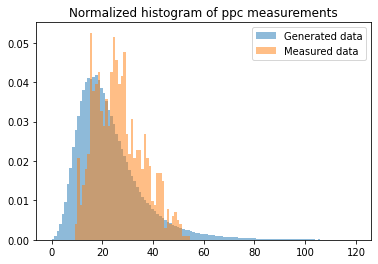

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.00000,NaN,0.00,0.00,0.00000,0.00,NaN,NaN,NaN
distance_coeff,0.00088,0.0098,0.31,-0.50,-0.00370,0.52,980.0,600.0,1.0
meal_prep_coeff,0.00280,0.0095,0.30,-0.47,0.00058,0.49,980.0,610.0,1.0
mean,3.00000,0.0034,0.10,2.80,3.00000,3.20,890.0,550.0,1.0
traffic_level_coeff[1],-0.01000,0.0098,0.31,-0.52,-0.00400,0.51,1008.0,624.0,1.0
...,...,...,...,...,...,...,...,...,...
delivery_times[996],22.00000,0.3200,10.00,9.70,20.00000,41.00,978.0,605.0,1.0
delivery_times[997],21.00000,0.2500,7.90,11.00,20.00000,36.00,993.0,614.0,1.0
delivery_times[998],22.00000,0.3300,11.00,9.50,20.00000,42.00,1036.0,641.0,1.0


In [14]:
model1_ppc=CmdStanModel(stan_file='model1_ppc.stan')

model1_ppc_sim=model1_ppc.sample(data={"N": len(train_df), "distance": train_df["Normalized distances"].values,
                           "meal_preparation_time": train_df["Normalized mealprep"].values,
                           "traffic_level" :train_df["Road_traffic_density"].values}, 
                     iter_sampling=999,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     seed=20230613,
                     output_dir='models_output/model1/ppc/')
model1_ppc_df = model1_ppc_sim.draws_pd()

# get measurements
model1_ppc_measurements = model1_ppc_sim.stan_variable('delivery_times').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0, 120, 120)
print(np.quantile(model1_ppc_measurements, 0.99))

# plot measurements
plt.hist(model1_ppc_measurements, density=True, bins=bins, alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
plt.hist(train_df["Time_taken(min)"], density=True, bins=bins, alpha=0.5, label="Measured data")

# plot customization
plt.legend()
plt.title("Normalized histogram of ppc measurements")
plt.show()

# display summary
model1_ppc_sim.summary()

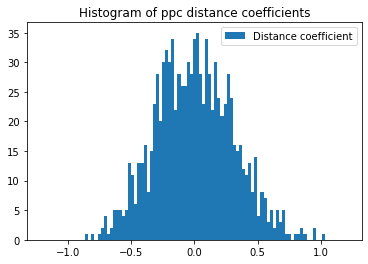

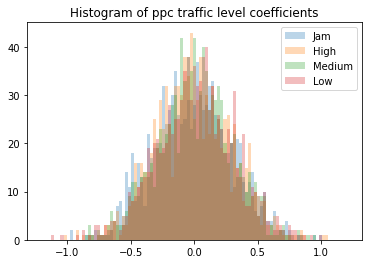

In [16]:
# get distance coeff
model1_ppc_distance_coeff = model1_ppc_sim.stan_variable('distance_coeff')

# plot traffic coeff
plt.hist(model1_ppc_distance_coeff,label="Distance coefficient", bins=np.linspace(-1.2,1.2,100))


# plot customization
plt.legend()
plt.title("Histogram of ppc distance coefficients")
plt.show()

# get traffic level coeff
model1_ppc_traffic_coeff = model1_ppc_sim.stan_variable('traffic_level_coeff')

# plot traffic coeff
plt.hist(model1_ppc_traffic_coeff[:,0],label="Jam", alpha=0.3, bins=np.linspace(-1.2,1.2,100))
plt.hist(model1_ppc_traffic_coeff[:,1],label="High", alpha=0.3, bins=np.linspace(-1.2,1.2,100))
plt.hist(model1_ppc_traffic_coeff[:,2],label="Medium", alpha=0.3, bins=np.linspace(-1.2,1.2,100))
plt.hist(model1_ppc_traffic_coeff[:,3],label="Low", alpha=0.3, bins=np.linspace(-1.2,1.2,100))

# plot customization
plt.legend()
plt.title("Histogram of ppc traffic level coefficients")
plt.show()


INFO:cmdstanpy:compiling stan file /home/project_repo/data_analytics_project/norm_fit.stan to exe file /home/project_repo/data_analytics_project/norm_fit


INFO:cmdstanpy:compiled model executable: /home/project_repo/data_analytics_project/norm_fit
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:01 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:14 Iteration:  100 / 2000 [  5%]  (Warmup)





chain 1 |██▎       | 00:37 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:46 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:57 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 01:06 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |████      | 01:15 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 01:22 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████     | 01:31 Iteration:  900 / 2000 [ 45%]  (Warmup)






chain 1 |█████▉    | 01:45 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▎   | 01:58 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 02:12 Iteration: 1200 / 2000 [ 60%


INFO:cmdstanpy:CmdStan done processing.


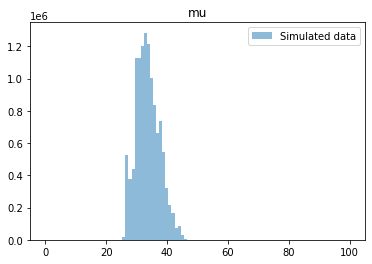

In [15]:
basic_fit=CmdStanModel(stan_file='norm_fit.stan')

basic_sample=basic_fit.sample(data={"N": len(train_df), 
                                    "distance": train_df["Normalized distances"].values,
                                    "meal_preparation_time": train_df["Normalized mealprep"].values, 
                                    "delivery_times": train_df["Time_taken(min)"].values, 
                                    "traffic_level" :train_df["Road_traffic_density"].values},
                     iter_sampling=1000,
                     iter_warmup=1000, 
                     chains=4,
                         )


df_fit = basic_sample.draws_pd()

temp=basic_sample.diagnose()
with open("output.txt", "w") as file:
    file.write(temp)

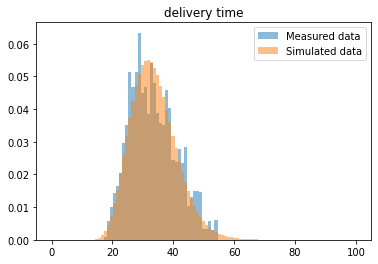

In [18]:
delivery_fit = df_fit.filter(regex="delivery_time.*")
# df_fit.iloc[:, 8:]
plt.hist(train_df["Time_taken(min)"], bins=bins,density=True, alpha=0.5, label="Measured data")
plt.hist(delivery_fit.values.flatten(),bins=bins,density=True, alpha=0.5, label="Simulated data")
plt.title("delivery time")
plt.legend()
plt.show()

# Model 2

In [16]:
train_df["Normalized person_rating"] = (train_df["Delivery_person_Ratings"] - train_df["Delivery_person_Ratings"].mean()) / train_df["Delivery_person_Ratings"].std()

# # train_df = train_df[train_df["Mean speed"] < 1.7]
# plt.hist(train_df["Normalized distances"], bins=20)
# plt.title("Normalized distances")
# plt.show()

# plt.hist(train_df["Normalized mealprep"], bins=20)
# plt.title("Normalized meal preparation time")
# plt.show()

# plt.hist(train_df["Normalized person_rating"], bins=20)
# plt.title("Normalized deliery person rating")
# plt.show()

# print(train_df["Road distances [km]"].mean())
# print(train_df["Time_taken(min)"].mean())
# print(train_df["Delivery_person_Ratings"].mean())


train_df["multiple_deliveries"] = train_df["multiple_deliveries"]+1


In [17]:
model_ppc=CmdStanModel(stan_file='model2_ppc.stan')

sim=model_ppc.sample(data={"N": len(train_df), "distance": train_df["Normalized distances"].values,
                           "meal_preparation_time": train_df["Normalized mealprep"].values,
                           "traffic_level": train_df["Road_traffic_density"].values,
                           "delivery_person_rating": train_df["Normalized person_rating"].values,
                           "number_of_deliveiers": train_df["multiple_deliveries"].values}, 
                     iter_sampling=1000,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     seed=20230613)
ppc_df = sim.draws_pd()

bins = np.linspace(0,100,100)

# mean_for_gamma = ppc_df.filter(regex="temp1.*")

# delivery = ppc_df.filter(regex="delivery_time.*")
# display(mean_for_gamma.iloc[:,:].describe())
# # delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# # delivery['value'].describe()
# # display(speed.loc[0,:].min())
# plt.hist(mean_for_gamma.values.flatten(), alpha=0.5, label="Mu")
# plt.title("Argument exponenty")
# plt.show()

# # mean_for_gamma = ppc_df.filter(regex="temp2.*")

# # delivery = ppc_df.filter(regex="delivery_time.*")
# # display(mean_for_gamma.iloc[0,:].describe())
# # # delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# # # delivery['value'].describe()
# # # display(speed.loc[0,:].min())
# # plt.hist(mean_for_gamma.values.flatten(), alpha=0.5, label="Mu")
# # plt.title("Exponenta bez dodawania meal prepa")
# # plt.show()

mean_for_gamma1 = ppc_df.filter(regex="mu.*")

# delivery = ppc_df.filter(regex="delivery_time.*")
display(mean_for_gamma1.iloc[0,:].describe())
# delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# delivery['value'].describe()
# display(speed.loc[0,:].min())
plt.hist(mean_for_gamma1.values.flatten(), alpha=0.5, label="Mu")
plt.title("Wynik exponenty")
plt.show()

# # sigma = ppc_df.filter(regex="sigma.*")
# # print(f"Odchylenie =  {sigma.values}")

# sigma = ppc_df.filter(regex="sigma.*")

# # delivery = ppc_df.filter(regex="delivery_time.*")
# display(sigma.iloc[:,:].describe())
# # delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# # delivery['value'].describe()
# # display(speed.loc[0,:].min())
# plt.hist(sigma.values.flatten(), alpha=0.5, label="sigma")
# plt.title("Odchylenie")
# plt.show()

# sigma = ppc_df.filter(regex="person_rating_coeff.*")

# delivery = ppc_df.filter(regex="delivery_time.*")
# display(sigma.iloc[:,:].describe())
# # delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# # delivery['value'].describe()
# # display(speed.loc[0,:].min())
# plt.hist(sigma.values.flatten(), alpha=0.5, label="sigma")
# plt.title("Delivery rating coeff")
# plt.show()

# # sigma = ppc_df.filter(regex="distance_coeff.*")
# # print(f"Wsp odległości =  {sigma.values}")

# # sigma = ppc_df.filter(regex="meal_prep_coeff.*")
# # print(f"Wsp przygotowania posiłku =  {sigma.values}")

# # mean_for_gamma2 = ppc_df.filter(regex="gamma_alpha.*")
# # # delivery = ppc_df.filter(regex="delivery_time.*")
# # display(mean_for_gamma2.iloc[0,:].describe())
# # # delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# # # delivery['value'].describe()
# # # display(speed.loc[0,:].min())
# # plt.hist(mean_for_gamma2.values.flatten(), alpha=0.5, label="Mu")
# # plt.title("gamma_alpha prior check")
# # plt.show()

# # mean_for_gamma3 = ppc_df.filter(regex="gamma_beta.*")
# # # delivery = ppc_df.filter(regex="delivery_time.*")
# # display(mean_for_gamma3.iloc[0,:].describe())
# # # delivery.iloc[:,:].apply(pd.DataFrame.describe, axis=1)
# # # delivery['value'].describe()
# # # display(speed.loc[0,:].min())
# # plt.hist(mean_for_gamma3.values.flatten(), alpha=0.5, label="Mu")
# # plt.title("gamma_beta prior check")
# # plt.show()

print(delivery.iloc[0,:].describe())
plt.hist(train_df["Time_taken(min)"],bins=bins ,alpha=0.5, label="Measured data", density=True)
plt.hist(delivery.values.flatten(),bins=bins, alpha=0.5, label="Simulated data", density=True)
plt.title("Time prior check")
plt.legend()
plt.show()


# print(f"distance_coef {ppc_df.filter(regex='distance_coeff.*')}")

INFO:cmdstanpy:compiling stan file /home/project_repo/data_analytics_project/model2_ppc.stan to exe file /home/project_repo/data_analytics_project/model2_ppc


ERROR:cmdstanpy:Stan program failed to compile:
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/project_repo/data_analytics_project/model2_ppc.hpp /home/project_repo/data_analytics_project/model2_ppc.stan
Syntax error in '/home/project_repo/data_analytics_project/model2_ppc.stan', line 37, column 3 to column 6, parsing error:
   -------------------------------------------------
    35:     real mean = normal_rng(3, 0.2)
    36:  
    37:     for (i in 1:N){
            ^
    38:        temp1[i] = distance_coeff*distance[i] + traffic_level_coeff[traffic_level[i]]+meal_prep_coeff*meal_preparation_time[i]+person_rating_coeff*delivery_person_rating[i]+deliveries_number_coeff[number_of_deliveiers[i]]+mean;
    39:        mu[i] = exp(distance_coeff*distance[i] + traffic_level_coeff[traffic_level[i]]+meal_prep_coeff*meal_preparation_time[i]+person_rating_coeff*delivery_person_rating[i]+deliveries_number_coeff[number_of_deliveiers[i]]+mean);
   ---------------------------------

ValueError: Unable to compile Stan model file: /home/project_repo/data_analytics_project/model2_ppc.stan.

In [ ]:
model2_fit=CmdStanModel(stan_file='model2_fit.stan')

model2_sample=model2_fit.sample(data={"N": len(train_df), 
                                    "distance": train_df["Normalized distances"].values,
                                    "meal_preparation_time": train_df["Normalized mealprep"].values, 
                                    "delivery_times": train_df["Time_taken(min)"].values, 
                                    "traffic_level" :train_df["Road_traffic_density"].values,
                                    "delivery_person_rating": train_df["Normalized person_rating"].values,
                                    "number_of_deliveiers": train_df["multiple_deliveries"].values}, 
                     iter_sampling=1000,
                     iter_warmup=1000, 
                     chains=4,
                         )


df_fit = model2_sample.draws_pd()
# display(df_fit)

# traffib_level = df_fit.filter(regex="distance_coef.*")
# # df_fit.iloc[:, 8:]
# # plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
# plt.hist(traffib_level.values.flatten(), alpha=0.5, label="Simulated data")
# plt.title("distance coef")
# plt.legend()
# plt.show()

# traffib_level = df_fit.filter(regex="meal_prep_coef.*")
# # df_fit.iloc[:, 8:]
# # plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
# plt.hist(traffib_level.values.flatten(), alpha=0.5, label="Simulated data")
# plt.title("meal prep coef")
# plt.legend()
# plt.show()

# traffib_level = df_fit.filter(regex="deliveries_number_coef.*")
# # df_fit.iloc[:, 8:]
# # plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
# plt.hist(traffib_level.values.flatten(), alpha=0.5, label="Simulated data")
# plt.title("Deliveries number coef")
# plt.legend()
# plt.show()

# traffib_level = df_fit.filter(regex="person_rating_coef.*")
# # df_fit.iloc[:, 8:]
# # plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
# plt.hist(traffib_level.values.flatten(), alpha=0.5, label="Simulated data")
# plt.title("Delivery rating coef")
# plt.legend()
# plt.show()


# traffib_level = df_fit.filter(regex="traffic_level_coef.*")
# # df_fit.iloc[:, 8:]
# # plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
# plt.hist(traffib_level.values.flatten(), alpha=0.5, label="Simulated data")
# plt.title("traffic level coef")
# plt.legend()
# plt.show()

# epx_argument = df_fit.filter(regex="exp_argument.*")
# # df_fit.iloc[:, 8:]
# # plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
# plt.hist(epx_argument.values.flatten(), alpha=0.5, label="Simulated data")
# plt.title("exp_argument")
# plt.legend()
# plt.show()

# epx_argument = df_fit.filter(regex="exp_argument_with.*")
# # df_fit.iloc[:, 8:]
# # plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
# plt.hist(epx_argument.values.flatten(), alpha=0.5, label="Simulated data")
# plt.title("exp_argument with meal")
# plt.legend()
# plt.show()

# mu = df_fit.filter(regex="mu.*")
# # df_fit.iloc[:, 8:]
# # plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
# plt.hist(mu.values.flatten(),bins=bins, alpha=0.5, label="Simulated data")
# plt.title("mu")
# plt.legend()
# plt.show()

# # travel_time = df_fit.filter(regex="travel_time.*")
# # # df_fit.iloc[:, 8:]
# # # plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
# # plt.hist(travel_time.values.flatten(),bins=np.linspace(0,100,100), alpha=0.5, label="Simulated data")
# # plt.title("travel time")
# # plt.legend()
# # plt.show()

# sigma = df_fit.filter(regex="sigma.*")
# # df_fit.iloc[:, 8:]
# # plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
# plt.hist(sigma.values.flatten(), alpha=0.5, label="Simulated data")
# plt.title("sigma")
# plt.legend()
# plt.show()



# delivery_fit = df_fit.filter(regex="delivery_time.*")
# # df_fit.iloc[:, 8:]
# plt.hist(train_df["Time_taken(min)"], bins=bins,density=True, alpha=0.5, label="Measured data")
# plt.hist(delivery_fit.values.flatten(),bins=bins,density=True, alpha=0.5, label="Simulated data")
# plt.title("delivery time")
# plt.legend()
# plt.show()

# # print(f"meal_prep_ceof {df_fit.filter(regex='meal_prep_coef.*')}")
# # print(f"distance_coef {df_fit.filter(regex='distance_coeff.*')}")
temp=model2_sample.diagnose()
with open("output2.txt", "w") as file:
    file.write(temp)

INFO:cmdstanpy:compiling stan file /home/project_repo/data_analytics_project/model2_fit.stan to exe file /home/project_repo/data_analytics_project/model2_fit
INFO:cmdstanpy:compiled model executable: /home/project_repo/data_analytics_project/model2_fit
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status





chain 1 |█▎        | 00:27 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:48 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 01:01 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 01:19 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 01:37 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 01:51 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████      | 02:05 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 02:22 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████▍    | 02:48 Iteration: 1000 / 2000 [ 50%]  (Warmup)



chain 1 |█


INFO:cmdstanpy:CmdStan done processing.


# Plots

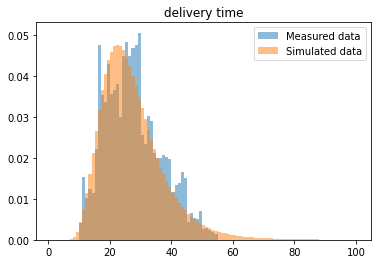

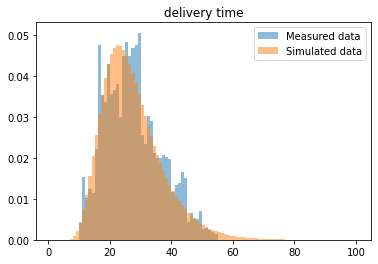

In [ ]:
model1_fit = basic_sample.draws_pd()
model2_fit = model2_sample.draws_pd()

bins = np.linspace(1,100,100)

delivery_fit = model1_fit.filter(regex="delivery_time.*")
# df_fit.iloc[:, 8:]
plt.hist(train_df["Time_taken(min)"], bins=bins,density=True, alpha=0.5, label="Measured data")
plt.hist(delivery_fit.values.flatten(),bins=bins,density=True, alpha=0.5, label="Simulated data")
plt.title("delivery time")
plt.legend()
plt.show()

delivery_fit = model2_fit.filter(regex="delivery_time.*")
# df_fit.iloc[:, 8:]
plt.hist(train_df["Time_taken(min)"], bins=bins,density=True, alpha=0.5, label="Measured data")
plt.hist(delivery_fit.values.flatten(),bins=bins,density=True, alpha=0.5, label="Simulated data")
plt.title("delivery time")
plt.legend()
plt.show()

# Comparison

In [ ]:
model1_az = az.from_cmdstanpy(
    posterior=basic_sample,
)

model2_az = az.from_cmdstanpy(
    posterior=model2_sample,
)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model2_1,0,-10157.466341,15.563251,0.000000,0.98785,43.842468,0.000000,False,log
model_1,1,-10652.505444,8.560998,495.039103,0.01215,39.463108,28.546822,False,log


Text(0.5, 1.0, 'Comparison of models with LOO criterion')

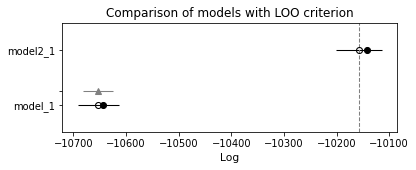

In [ ]:
compare_dict = {"model_1": model1_az, "model2_1": model2_az}

loo_diff = az.compare(compare_dict=compare_dict, ic="loo")
display(loo_diff)

ax = az.plot_compare(loo_diff)
ax.set_title("Comparison of models with LOO criterion")

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model2_1,0,-10157.403675,15.500584,0.000000,0.98786,43.830842,0.000000,True,log
model_1,1,-10652.505105,8.560660,495.101431,0.01214,39.463109,28.530552,False,log


Text(0.5, 1.0, 'Comparison of models with WAIC criterion')

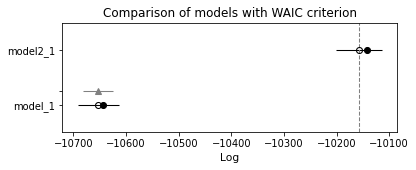

In [ ]:
compare_dict = {"model_1": model1_az, "model2_1": model2_az}

loo_diff = az.compare(compare_dict=compare_dict, ic="waic")
display(loo_diff)

ax = az.plot_compare(loo_diff)
ax.set_title("Comparison of models with WAIC criterion")